<a href="https://colab.research.google.com/github/SriVidyaYeluripati/Data-Assimilation/blob/main/ai_based_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-by-Step Plan to Generate Synthetic 1D Data (Based on the Paper)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def generate_synthetic_1d_data(
    n_points=100,
    n_observations=10,
    obs_noise_std=0.1,
    shift=0.0,
    amplitude=1.0,
    frequency=2 * np.pi,
    seed=None,
    field_type='sine'  # can be 'sine' or 'parabola'
):
    if seed is not None:
        np.random.seed(seed)

    # 1. Create 1D spatial domain [0, 1]
    x = np.linspace(0, 1, n_points)

    # 2. Generate true field
    if field_type == 'sine':
        true_field = amplitude * np.sin(frequency * (x + shift))
    elif field_type == 'parabola':
        true_field = amplitude * (1 - (2 * x - 1) ** 2)
    else:
        raise ValueError("field_type must be 'sine' or 'parabola'")

    # 3. Background (first guess) - zero
    background = np.zeros_like(true_field)

    # 4. Sample random observation locations
    obs_indices = np.sort(np.random.choice(n_points, n_observations, replace=False))
    obs_positions = x[obs_indices]
    obs_values = true_field[obs_indices] + np.random.normal(0, obs_noise_std, size=n_observations)

    # 5. Return components
    return {
        "x": x,
        "true_field": true_field,
        "background": background,
        "obs_indices": obs_indices,
        "obs_positions": obs_positions,
        "obs_values": obs_values,
        "field_type": field_type  # for labeling
    }





##  **Next Step: Define the Observation Operator $H$**



In variational data assimilation, $H$ maps the full field to the observation space. Since our model predicts the **full field**, and the observations are only available at **certain indices**, you need a way to:

$$
H(x) = x[\text{obs_indices}]
$$

That means: from a full predicted field, extract only the values at observed points to compute the cost.











###  **Step 2: Define the Loss Function**

Here’s a PyTorch version of the 1D cost function:

$$
J(\hat{x}) = \frac{1}{B} \sum_i (\hat{x}_i - x_{b,i})^2 + \frac{1}{R} \sum_j (H(\hat{x})_j - y_j)^2
$$

We'll make this modular so it works even when you later switch to 2D or change $H$, $B$, or $R$.

In [ ]:
import torch

def da_loss_1d(
    pred_field,     # model output: shape (n_points,)
    background,     # first guess: shape (n_points,)
    obs_indices,    # indices of observations
    obs_values,     # shape (n_observations,)
    B=1.0,          # background variance (scalar)
    R=0.01          # observation variance (scalar)
):
    # Term 1: Background agreement
    background_term = torch.mean((pred_field - background)**2) / B

    # Term 2: Observation agreement (apply H by indexing)
    H_pred = pred_field[obs_indices]
    observation_term = torch.mean((H_pred - obs_values)**2) / R

    return background_term + observation_term


## SimpleMLP Model Definition
For now, we’ll keep it simple:

Input: [background, observation mask, interpolated obs] → shape: (n_points, features)

Output: predicted analysis x_pred (same shape as background)

In [ ]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, n_points, input_dim=3, hidden_dim=64):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_points * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_points)
        )

    def forward(self, x_b, obs_values, obs_indices, n_points):
        # Create observation vector and mask
        obs_vector = torch.zeros_like(x_b)
        obs_mask = torch.zeros_like(x_b)

        obs_vector[obs_indices] = obs_values
        obs_mask[obs_indices] = 1.0

        # Stack inputs
        input_tensor = torch.stack([x_b, obs_mask, obs_vector], dim=1)  # shape (n_points, 3)
        input_tensor = input_tensor.flatten().unsqueeze(0)  # shape (1, n_points * 3)

        return self.model(input_tensor).squeeze(0)  # shape (n_points,)


Input is flattened: shape becomes [1, n_points * 3]

We provide:

*   x_b: background values
*   obs_mask: tells the model where observations exist

*   obs_vector: holds the observed values (0 elsewhere)

So the model learns to use the pattern of observations + background to infer the full corrected field.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

field_types = ['sine', 'parabola']
results = {}

for field_type in field_types:
    print(f"\n🔁 Training on field type: {field_type.upper()}")

    # Step 1: Generate synthetic data
    data = generate_synthetic_1d_data(
        n_points=100,
        n_observations=10,
        seed=0,
        field_type=field_type
    )

    x_true = torch.tensor(data["true_field"], dtype=torch.float32)
    x_b = torch.tensor(data["background"], dtype=torch.float32)
    obs_indices = torch.tensor(data["obs_indices"], dtype=torch.long)
    obs_values = torch.tensor(data["obs_values"], dtype=torch.float32)

    # 🔁 Normalize background and observations (mean 0, std 1)
    x_b_mean = x_b.mean()
    x_b_std = x_b.std() + 1e-8  # add small value to avoid division by 0

    x_b_norm = (x_b - x_b_mean) / x_b_std
    obs_values_norm = (obs_values - x_b_mean) / x_b_std


    # Step 2: Create model and optimizer
    model = SimpleMLP(n_points=100, hidden_dim=128)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Step 3: Training
    n_epochs = 1000
    loss_history = []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        x_pred = model(x_b, obs_values, obs_indices, n_points=100)
        loss = da_loss_1d(x_pred, x_b, obs_indices, obs_values, B=1.0, R=0.01)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | {field_type} Loss = {loss.item():.6f}")

    # Save prediction & info for Step 4
    results[field_type] = {
        "x_pred": model(x_b, obs_values, obs_indices, n_points=100).detach().numpy(),
        "true_field": data["true_field"],
        "background": data["background"],
        "x": data["x"],
        "obs_positions": data["obs_positions"],
        "obs_values": data["obs_values"],
        "loss_history": loss_history,
    }

print("\n✅ Training complete for both sine and parabola.")



🔁 Training on field type: SINE
Epoch 000 | sine Loss = 48.285725
Epoch 050 | sine Loss = 0.098414
Epoch 100 | sine Loss = 0.053955
Epoch 150 | sine Loss = 0.053608
Epoch 200 | sine Loss = 0.053607
Epoch 250 | sine Loss = 0.053607
Epoch 300 | sine Loss = 0.053607
Epoch 350 | sine Loss = 0.053607
Epoch 400 | sine Loss = 0.053607
Epoch 450 | sine Loss = 0.053607
Epoch 500 | sine Loss = 0.053607
Epoch 550 | sine Loss = 0.053607
Epoch 600 | sine Loss = 0.053607
Epoch 650 | sine Loss = 0.053607
Epoch 700 | sine Loss = 0.053607
Epoch 750 | sine Loss = 0.053607
Epoch 800 | sine Loss = 0.053607
Epoch 850 | sine Loss = 0.053609
Epoch 900 | sine Loss = 0.053607
Epoch 950 | sine Loss = 0.053611

🔁 Training on field type: PARABOLA
Epoch 000 | parabola Loss = 42.970215
Epoch 050 | parabola Loss = 0.069112
Epoch 100 | parabola Loss = 0.043715
Epoch 150 | parabola Loss = 0.043530
Epoch 200 | parabola Loss = 0.043528
Epoch 250 | parabola Loss = 0.043528
Epoch 300 | parabola Loss = 0.043528
Epoch 350 |

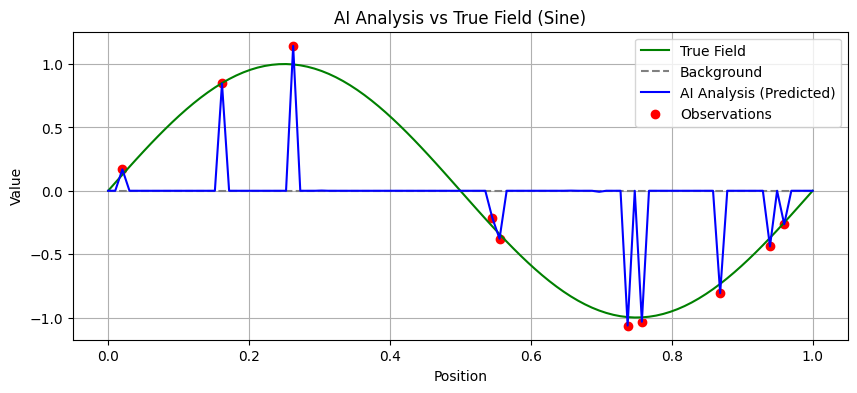

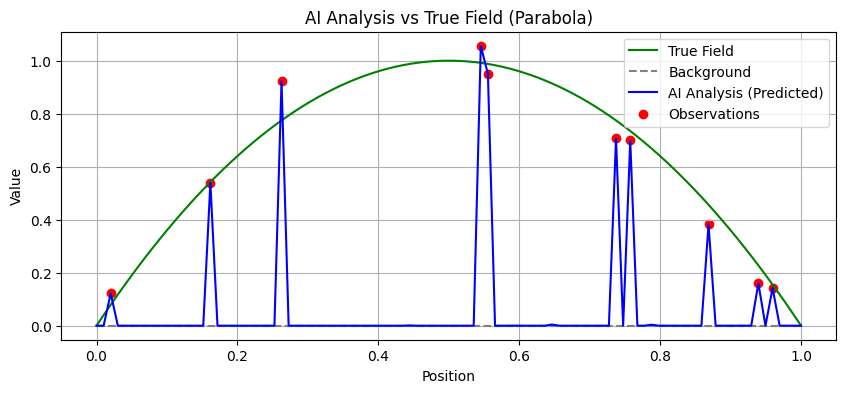

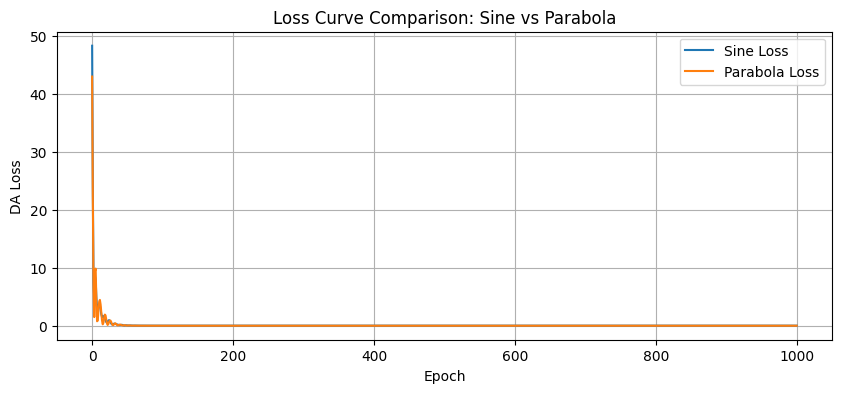

In [ ]:
import matplotlib.pyplot as plt

# Step 4a: Plot predicted field vs true field for each case
for field_type in ['sine', 'parabola']:
    r = results[field_type]

    plt.figure(figsize=(10, 4))
    plt.plot(r["x"], r["true_field"], label="True Field", color='green')
    plt.plot(r["x"], r["background"], label="Background", linestyle='--', color='gray')
    plt.plot(r["x"], r["x_pred"], label="AI Analysis (Predicted)", color='blue')
    plt.scatter(r["obs_positions"], r["obs_values"], label="Observations", color='red')
    plt.title(f"AI Analysis vs True Field ({field_type.capitalize()})")
    plt.xlabel("Position")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 4b: Plot training loss curves together
plt.figure(figsize=(10, 4))
for field_type in ['sine', 'parabola']:
    loss_curve = results[field_type]["loss_history"]
    plt.plot(loss_curve, label=f'{field_type.capitalize()} Loss')
plt.title("Loss Curve Comparison: Sine vs Parabola")
plt.xlabel("Epoch")
plt.ylabel("DA Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Add metrics to each result
for field_type in results:
    r = results[field_type]

    x_pred = np.array(r["x_pred"])
    x_true = np.array(r["true_field"])

    mae = mean_absolute_error(x_true, x_pred)
    mse = mean_squared_error(x_true, x_pred)
    rmse = np.sqrt(mse)

    results[field_type]["mae"] = mae
    results[field_type]["mse"] = mse
    results[field_type]["rmse"] = rmse

    print(f"\n📊 Metrics for {field_type.upper()}:")
    print(f"   MAE  = {mae:.6f}")
    print(f"   MSE  = {mse:.6f}")
    print(f"   RMSE = {rmse:.6f}")



📊 Metrics for SINE:
   MAE  = 0.576179
   MSE  = 0.448840
   RMSE = 0.669955

📊 Metrics for PARABOLA:
   MAE  = 0.608234
   MSE  = 0.485622
   RMSE = 0.696866


# Adding smoothness to loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Smoothness penalty function
def smoothness_penalty(x_pred):
    return torch.mean((x_pred[1:] - x_pred[:-1])**2)

# Extended MLP with 2 hidden layers
class DeepMLP(nn.Module):
    def __init__(self, n_points, input_dim=3, hidden_dim=128):
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_points * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_points)
        )

    def forward(self, x_b, obs_values, obs_indices, n_points):
        obs_vector = torch.zeros_like(x_b)
        obs_mask = torch.zeros_like(x_b)
        obs_vector[obs_indices] = obs_values
        obs_mask[obs_indices] = 1.0
        input_tensor = torch.stack([x_b, obs_mask, obs_vector], dim=1)
        input_tensor = input_tensor.flatten().unsqueeze(0)
        return self.model(input_tensor).squeeze(0)

# Loop through sine and parabola
field_types = ['sine', 'parabola']
results = {}

for field_type in field_types:
    print(f"\n🔁 Training on field type: {field_type.upper()}")

    # Step 1: Generate synthetic data
    data = generate_synthetic_1d_data(
        n_points=100,
        n_observations=10,
        seed=0,
        field_type=field_type
    )

    x_true = torch.tensor(data["true_field"], dtype=torch.float32)
    x_b = torch.tensor(data["background"], dtype=torch.float32)
    obs_indices = torch.tensor(data["obs_indices"], dtype=torch.long)
    obs_values = torch.tensor(data["obs_values"], dtype=torch.float32)

    # Normalize inputs
    x_b_mean = x_b.mean()
    x_b_std = x_b.std() + 1e-8
    x_b_norm = (x_b - x_b_mean) / x_b_std
    obs_values_norm = (obs_values - x_b_mean) / x_b_std

    # Create model and optimizer
    model = DeepMLP(n_points=100)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train
    n_epochs = 1000
    λ_smooth = 0.1
    loss_history = []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        x_pred_norm = model(x_b_norm, obs_values_norm, obs_indices, n_points=100)
        loss = da_loss_1d(x_pred_norm, x_b_norm, obs_indices, obs_values_norm, B=1.0, R=0.01)
        loss += λ_smooth * smoothness_penalty(x_pred_norm)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | {field_type} Loss = {loss.item():.6f}")

    # Denormalize prediction
    x_pred = x_pred_norm.detach() * x_b_std + x_b_mean

    # Save results
    results[field_type] = {
        "x_pred": x_pred.numpy(),
        "true_field": data["true_field"],
        "background": data["background"],
        "x": data["x"],
        "obs_positions": data["obs_positions"],
        "obs_values": data["obs_values"],
        "loss_history": loss_history,
    }

print("\n✅ Training complete for both sine and parabola.")



🔁 Training on field type: SINE
Epoch 000 | sine Loss = 544285262503477248.000000
Epoch 050 | sine Loss = 1141145698566144.000000
Epoch 100 | sine Loss = 632572178595840.000000
Epoch 150 | sine Loss = 631546419609600.000000
Epoch 200 | sine Loss = 631539373178880.000000
Epoch 250 | sine Loss = 631539373178880.000000
Epoch 300 | sine Loss = 631539373178880.000000
Epoch 350 | sine Loss = 631539306070016.000000
Epoch 400 | sine Loss = 631539238961152.000000
Epoch 450 | sine Loss = 631539373178880.000000
Epoch 500 | sine Loss = 631539238961152.000000
Epoch 550 | sine Loss = 631539306070016.000000
Epoch 600 | sine Loss = 631541856206848.000000
Epoch 650 | sine Loss = 631539574505472.000000
Epoch 700 | sine Loss = 631539373178880.000000
Epoch 750 | sine Loss = 631540312702976.000000
Epoch 800 | sine Loss = 631539373178880.000000
Epoch 850 | sine Loss = 631540044267520.000000
Epoch 900 | sine Loss = 631567626010624.000000
Epoch 950 | sine Loss = 631573665808384.000000

🔁 Training on field typ

# 2D data

In [ ]:
# Make sure PyTorch and other essentials are installed (Colab has them by default)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
def generate_synthetic_2d_data(grid_size=32, n_observations=50, noise_std=0.1, seed=42, pattern='gaussian'):
    np.random.seed(seed)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)

    if pattern == 'gaussian':
        field = np.exp(-((xx - 0.5)**2 + (yy - 0.5)**2) / 0.02)
    elif pattern == 'sine':
        field = np.sin(2 * np.pi * xx) * np.sin(2 * np.pi * yy)
    else:
        raise ValueError("Unsupported pattern")

    background = np.zeros_like(field)

    indices = np.random.choice(grid_size * grid_size, n_observations, replace=False)
    obs_coords = np.array(np.unravel_index(indices, (grid_size, grid_size))).T
    obs_values = field[obs_coords[:, 0], obs_coords[:, 1]] + np.random.normal(0, noise_std, size=n_observations)

    return {
        "field": field,
        "background": background,
        "obs_coords": obs_coords,
        "obs_values": obs_values,
        "grid_size": grid_size,
        "xx": xx,
        "yy": yy
    }


##  Define CNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.model(x)


## Define DA Loss Function

In [ ]:
def da_loss_2d(pred, background, obs_coords, obs_values, B=1.0, R=0.01):
    background_term = torch.mean((pred - background)**2) / B
    obs_term = 0.0
    for (i, j), val in zip(obs_coords, obs_values):
        obs_term += (pred[0, 0, i, j] - val) ** 2
    obs_term /= (R * len(obs_values))
    return background_term + obs_term


## Training Function

In [ ]:
def train_2d_ai_var(data, n_epochs=500, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    field = torch.tensor(data["field"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    background = torch.tensor(data["background"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    obs_coords = torch.tensor(data["obs_coords"], dtype=torch.long)
    obs_values = torch.tensor(data["obs_values"], dtype=torch.float32).to(device)

    obs_mask = torch.zeros_like(background)
    obs_layer = torch.zeros_like(background)
    for idx, (i, j) in enumerate(data["obs_coords"]):
        obs_mask[0, 0, i, j] = 1.0
        obs_layer[0, 0, i, j] = data["obs_values"][idx]

    input_tensor = torch.cat([background, obs_mask, obs_layer], dim=1)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor)
        loss = da_loss_2d(output, background, obs_coords, obs_values)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | Loss = {loss.item():.6f}")

    pred = model(input_tensor).detach().cpu().numpy().squeeze()
    return pred, loss_history, data["field"]


## Run Pipeline + Evaluate

In [ ]:
# Generate synthetic 2D data
data = generate_synthetic_2d_data(grid_size=32, n_observations=100, pattern='gaussian')

# Train model
pred, loss_history, true_field = train_2d_ai_var(data)

# Metrics
true = true_field.flatten()
pred_flat = pred.flatten()
mae = mean_absolute_error(true, pred_flat)
rmse = np.sqrt(mean_squared_error(true, pred_flat))

print(f"\n📊 MAE  = {mae:.6f}")
print(f"📊 RMSE = {rmse:.6f}")


Epoch 000 | Loss = 5.414146
Epoch 050 | Loss = 0.025913
Epoch 100 | Loss = 0.008123
Epoch 150 | Loss = 0.006985
Epoch 200 | Loss = 0.006633
Epoch 250 | Loss = 0.006468
Epoch 300 | Loss = 0.006371
Epoch 350 | Loss = 0.006308
Epoch 400 | Loss = 0.006261
Epoch 450 | Loss = 0.006224

📊 MAE  = 0.066750
📊 RMSE = 0.163059


## Visualizations

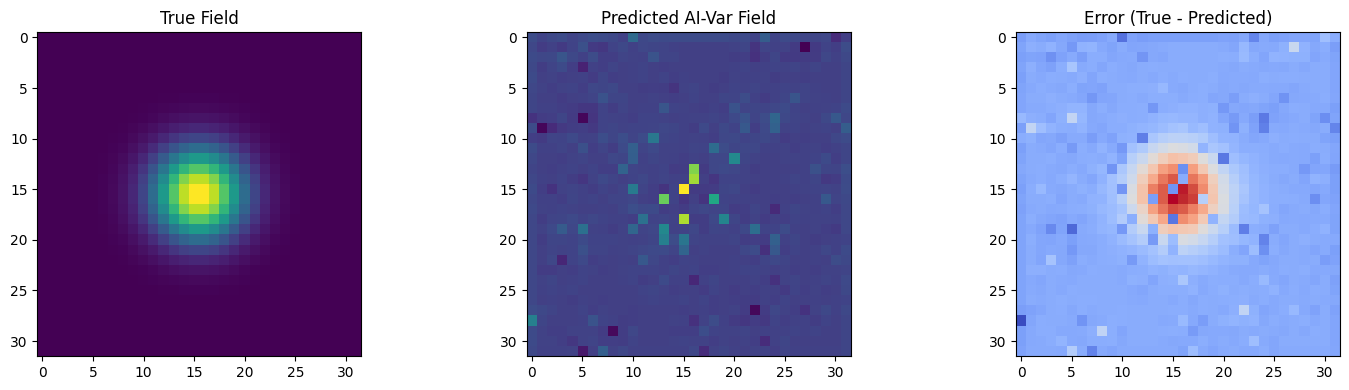

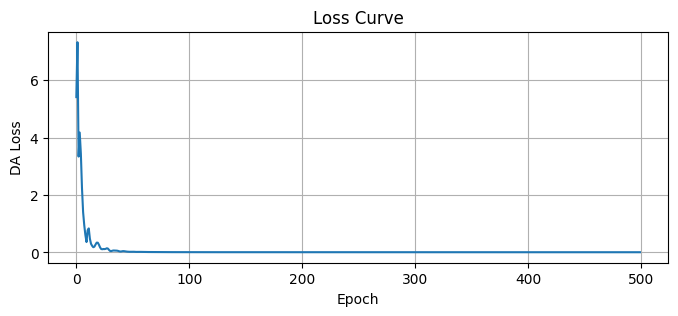

In [ ]:
# Predicted vs true fields
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(true_field, cmap='viridis')
axs[0].set_title("True Field")
axs[1].imshow(pred, cmap='viridis')
axs[1].set_title("Predicted AI-Var Field")
axs[2].imshow(true_field - pred, cmap='coolwarm')
axs[2].set_title("Error (True - Predicted)")
plt.tight_layout()
plt.show()

# Loss curve
plt.figure(figsize=(8, 3))
plt.plot(loss_history)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("DA Loss")
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Generate a sinusoidal 2D field
data_sine = generate_synthetic_2d_data(grid_size=32, n_observations=100, pattern='sine')

# Step 2: Train the AI-Var model on sinusoidal data
pred_sine, loss_sine, true_sine = train_2d_ai_var(data_sine)

# Step 3: Baseline (zero field = background)
baseline = data_sine['background']

# Step 4: Metrics
true = true_sine.flatten()
pred_flat = pred_sine.flatten()
baseline_flat = baseline.flatten()

mae_pred = mean_absolute_error(true, pred_flat)
rmse_pred = np.sqrt(mean_squared_error(true, pred_flat))

mae_base = mean_absolute_error(true, baseline_flat)
rmse_base = np.sqrt(mean_squared_error(true, baseline_flat))

print(f"\n📊 AI-Var on Sinusoidal Field:")
print(f"   MAE  = {mae_pred:.6f}")
print(f"   RMSE = {rmse_pred:.6f}")

print(f"\n📉 Baseline (Zero Field):")
print(f"   MAE  = {mae_base:.6f}")
print(f"   RMSE = {rmse_base:.6f}")


Epoch 000 | Loss = 24.831165
Epoch 050 | Loss = 0.052175
Epoch 100 | Loss = 0.031680
Epoch 150 | Loss = 0.027465
Epoch 200 | Loss = 0.025875
Epoch 250 | Loss = 0.090149
Epoch 300 | Loss = 0.024961
Epoch 350 | Loss = 0.024585
Epoch 400 | Loss = 0.024432
Epoch 450 | Loss = 0.024331

📊 AI-Var on Sinusoidal Field:
   MAE  = 0.348463
   RMSE = 0.455237

📉 Baseline (Zero Field):
   MAE  = 0.379699
   RMSE = 0.484375


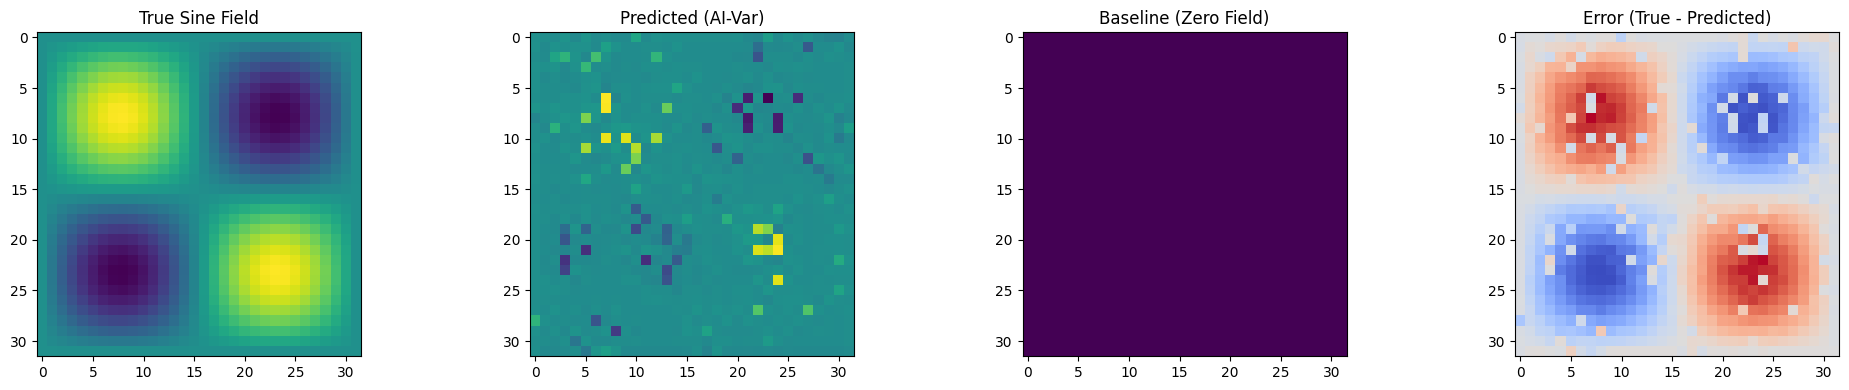

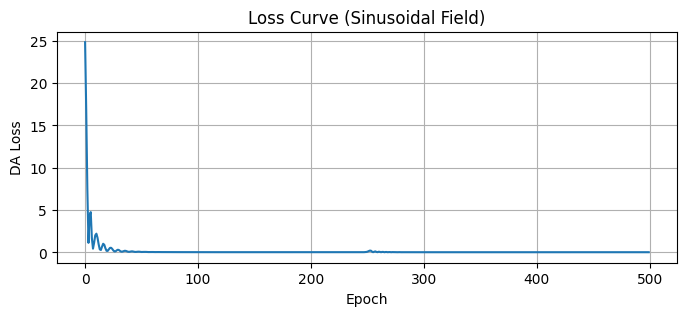

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(true_sine, cmap='viridis')
axs[0].set_title("True Sine Field")
axs[1].imshow(pred_sine, cmap='viridis')
axs[1].set_title("Predicted (AI-Var)")
axs[2].imshow(baseline, cmap='viridis')
axs[2].set_title("Baseline (Zero Field)")
axs[3].imshow(true_sine - pred_sine, cmap='coolwarm')
axs[3].set_title("Error (True - Predicted)")
plt.tight_layout()
plt.show()

# Loss curve
plt.figure(figsize=(8, 3))
plt.plot(loss_sine)
plt.title("Loss Curve (Sinusoidal Field)")
plt.xlabel("Epoch")
plt.ylabel("DA Loss")
plt.grid(True)
plt.show()


In [ ]:
def train_ai_var_2d(data, model_fn, loss_fn, n_epochs=500, lr=0.01, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare tensors
    field = torch.tensor(data["field"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    background = torch.tensor(data["background"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    obs_coords = torch.tensor(data["obs_coords"], dtype=torch.long)
    obs_values = torch.tensor(data["obs_values"], dtype=torch.float32).to(device)

    # Build input: [background, obs_mask, obs_layer]
    obs_mask = torch.zeros_like(background)
    obs_layer = torch.zeros_like(background)
    for idx, (i, j) in enumerate(data["obs_coords"]):
        obs_mask[0, 0, i, j] = 1.0
        obs_layer[0, 0, i, j] = data["obs_values"][idx]

    input_tensor = torch.cat([background, obs_mask, obs_layer], dim=1)

    # Model + Optimizer
    model = model_fn().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    loss_history = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(input_tensor)
        loss = loss_fn(pred, background, obs_coords, obs_values)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if verbose and epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | Loss = {loss.item():.6f}")

    # Final prediction
    pred = model(input_tensor).detach().cpu().numpy().squeeze()
    return pred, loss_history, data["field"]


In [ ]:
def run_experiment(field_type='gaussian', loss_fn=da_loss_2d, model_fn=SimpleCNN, n_observations=100, label=None):
    print(f"\n🚀 Running AI-Var on {field_type.upper()} field")
    data = generate_synthetic_2d_data(grid_size=32, n_observations=n_observations, pattern=field_type)
    pred, loss_hist, true_field = train_ai_var_2d(data, model_fn, loss_fn, n_epochs=500, verbose=True)

    # Compute metrics
    true_flat = true_field.flatten()
    pred_flat = pred.flatten()
    baseline_flat = data["background"].flatten()

    metrics = {
        "Field": field_type,
        "Label": label or loss_fn.__name__,
        "MAE_Pred": mean_absolute_error(true_flat, pred_flat),
        "RMSE_Pred": np.sqrt(mean_squared_error(true_flat, pred_flat)),
        "MAE_Base": mean_absolute_error(true_flat, baseline_flat),
        "RMSE_Base": np.sqrt(mean_squared_error(true_flat, baseline_flat)),
    }

    # Visualize
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    axs[0].imshow(true_field, cmap='viridis')
    axs[0].set_title("True Field")
    axs[1].imshow(pred, cmap='viridis')
    axs[1].set_title("AI-Var Prediction")
    axs[2].imshow(data["background"], cmap='viridis')
    axs[2].set_title("Baseline (Zero Field)")
    axs[3].imshow(true_field - pred, cmap='coolwarm')
    axs[3].set_title("Error Map")
    plt.suptitle(f"{field_type.upper()} Field — {label or loss_fn.__name__}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Loss curve
    plt.figure(figsize=(7, 3))
    plt.plot(loss_hist)
    plt.title(f"Loss Curve — {field_type.upper()} ({label or loss_fn.__name__})")
    plt.xlabel("Epoch")
    plt.ylabel("DA Loss")
    plt.grid(True)
    plt.show()

    return metrics



🚀 Running AI-Var on GAUSSIAN field
Epoch 000 | Loss = 5.217266
Epoch 050 | Loss = 0.020290
Epoch 100 | Loss = 0.007907
Epoch 150 | Loss = 0.006720
Epoch 200 | Loss = 0.006389
Epoch 250 | Loss = 0.006257
Epoch 300 | Loss = 0.006191
Epoch 350 | Loss = 0.006156
Epoch 400 | Loss = 0.006131
Epoch 450 | Loss = 0.006112


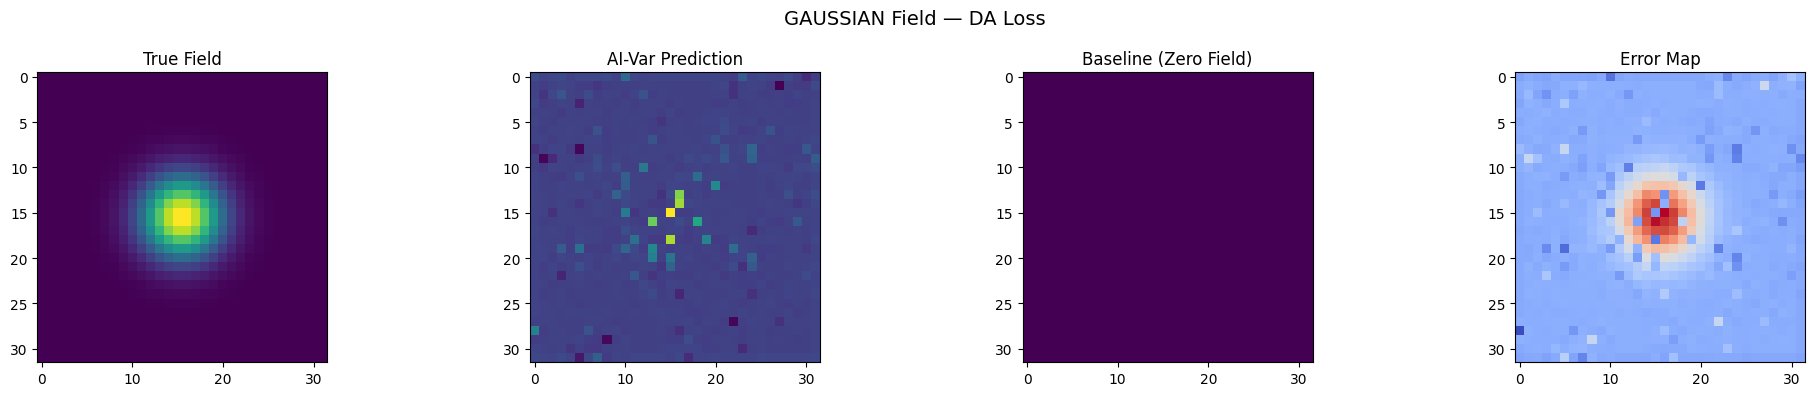

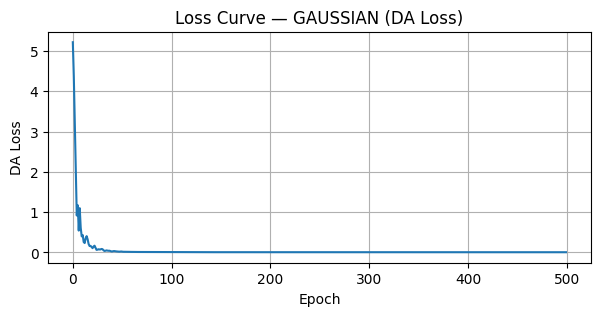


🚀 Running AI-Var on SINE field
Epoch 000 | Loss = 25.685720
Epoch 050 | Loss = 0.062482
Epoch 100 | Loss = 0.029204
Epoch 150 | Loss = 0.026259
Epoch 200 | Loss = 0.026254
Epoch 250 | Loss = 0.024815
Epoch 300 | Loss = 0.024597
Epoch 350 | Loss = 0.025176
Epoch 400 | Loss = 0.024269
Epoch 450 | Loss = 0.024404


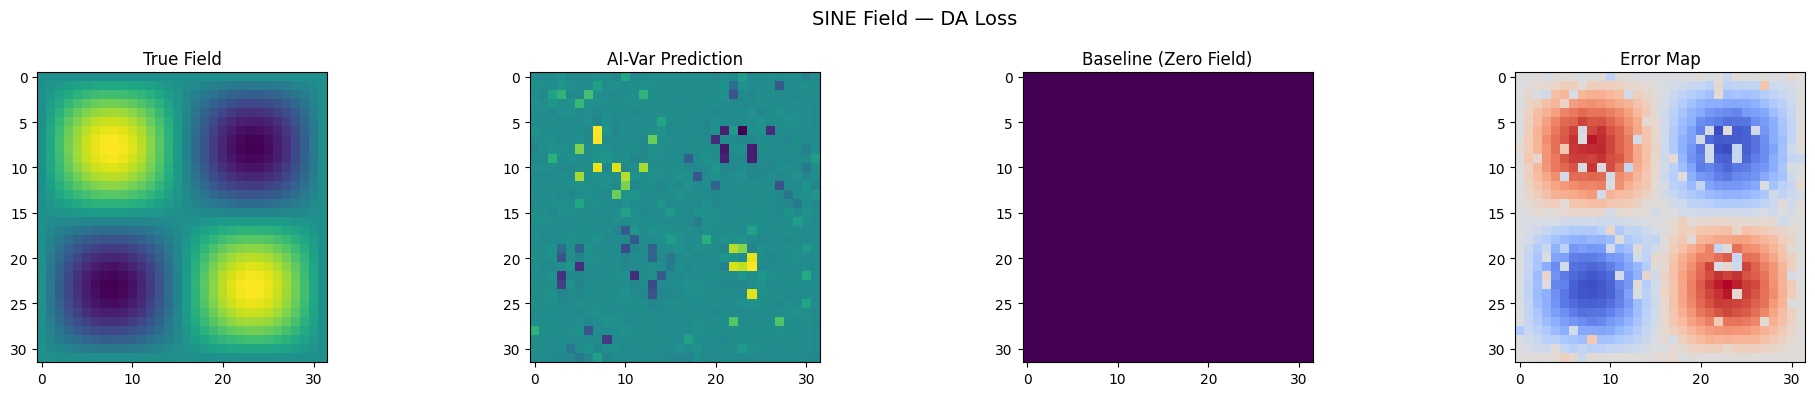

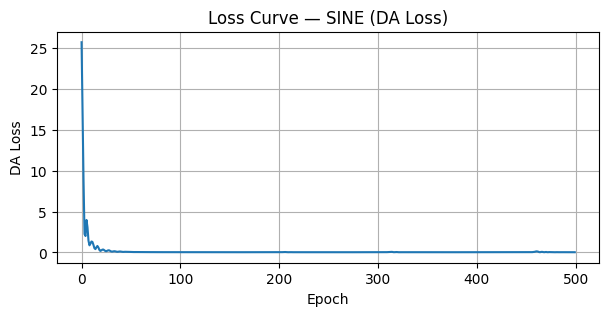

,Field,Label,MAE_Pred,RMSE_Pred,MAE_Base,RMSE_Base
0,gaussian,DA Loss,0.064717,0.162375,0.058966,0.171706
1,sine,DA Loss,0.351150,0.458976,0.379699,0.484375


In [ ]:
results = []

# Run on Gaussian
results.append(run_experiment(field_type='gaussian', loss_fn=da_loss_2d, label="DA Loss"))

# Run on Sinusoidal
results.append(run_experiment(field_type='sine', loss_fn=da_loss_2d, label="DA Loss"))

# Display all results as a table
import pandas as pd
df_results = pd.DataFrame(results)
df_results
